In [1]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
FSelection_dir = "./FSel/"

### Feature Selection

In [ ]:
# Set the pyemma environment
import pyemma
import pyemma.coordinates
from pyemma.coordinates import tica
sys.path.insert(0, './scripts')
import FeatureSelection

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
import sys

In [ ]:
# Load the featurized trajectories
ftrajs = []
for i in range(153):
    traj = np.load(Featurization_dir +'ftraj_%03d.npy'%i, allow_pickle=True)
    ftrajs.append(traj)

# Set the parameters
n_features = ftrajs[0].shape[1] # the number of all the features from featurization, 528 here
lt = 100 # the lagtime of the time-lagged correlation matrix 
n_timescales = 3 # the number of dynamic modes considered in validation
num_every_iter = 2 # the number of selected features in each iteration

# Feature Selection
featureselect = FeatureSelection.spectral_oasis(num_select=n_features, num_every_iter=num_every_iter, 
                                                method='spectral-oasis', random_seed=42, 
                                                covariance=False)
featureselect.select(ftrajs, lagtime=lt)
select_columns = featureselect.select_columns
np.save(Featurization_dir + "select_columns.npy", featureselect.select_columns)

# Feature Selection Validation based on tICA timescales
timescales = []
for i in range(int(n_features//num_every_iter)):
    num_sel_cols = num_every_iter * (i+1)
    
    # Skip when the number of selected features is smaller than the number of pre-set dynamic modes
    if num_sel_cols < n_timescales:
        continue
        
    # Calculate the timescales of the trajectories with the selected features
    oasistrajs = []
    for key in range(len(ftrajs)):
        oasistrajs.append(ftrajs[key][:, select_columns[:num_sel_cols]])
        
    TICA = tica(lag=100, dim=n_timescales, kinetic_map=True, 
                reversible=True, var_cutoff=1, epsilon=0)
    TICA.fit(oasistrajs)
    timescales.append([num_sel_cols, TICA.timescales[:n_timescales]])
    del TICA
    
if n_features % num_every_iter != 0:
    TICA = tica(lag=100, dim=n_timescales, kinetic_map=True, 
                reversible=True, var_cutoff=1, epsilon=0)
    TICA.fit(ftrajs)
    timescales.append([n_features, TICA.timescales[:n_timescales]])
    
timescales = np.array(timescales, dtype=object)
np.save(Featurization_dir + 'timescales.npy', timescales)

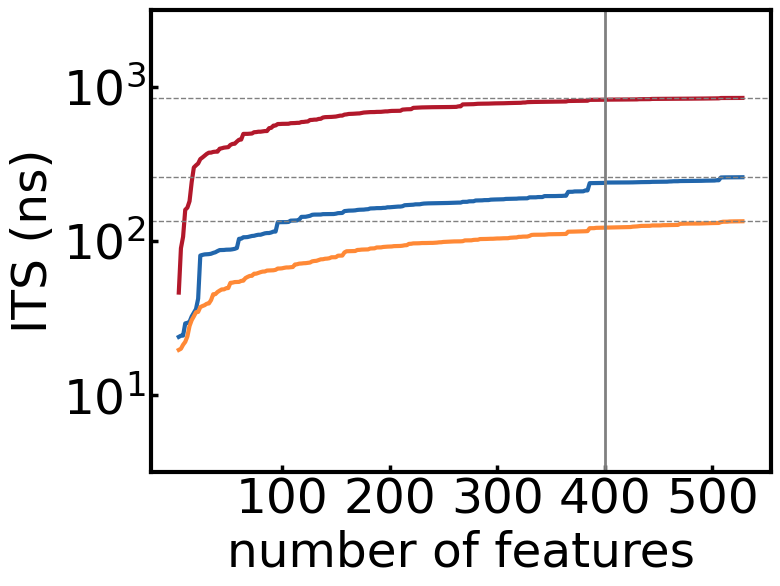

In [17]:
delta_t = 0.2 # unit time of each frame, here in nanosecond
timescales = np.load(FSelection_dir + "timescales.npy", allow_pickle=True)

# Take the logarithm
log_timescales = np.zeros((len(timescales), 3))
for i in range(len(timescales)):
    log_timescales[i] = np.log10(timescales[:, 1][i] * delta_t)
    
plt.rcParams['font.size'] = 35
colors = ['#b2182b','#2166ac','#ff8936']

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    plt.plot(timescales[:, 0], log_timescales[:,i], linewidth=3, color=colors[i])
    plt.axhline(y= log_timescales[-1,i], color='grey', linewidth=1, linestyle='--')
plt.axvline(x=400, color='grey', linewidth=2, linestyle='-')
plt.xlabel('number of features')
plt.ylabel('ITS (ns)')
plt.yticks([1, 2, 3], labels=['$10^{1}$', '$10^{2}$', '$10^{3}$'])
plt.xticks([100, 200, 300, 400, 500])
plt.ylim(0.5, 3.5)
ax.tick_params(axis='both', direction='in', width=2.5, length=5)
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.savefig('./png/spectral_oasis.png', dpi=900, bbox_inches='tight')
plt.show()

In [ ]:
# The timescales converge when the number of features is more than 400
# Generate the trajectories with the selected 400 features
num_sel_cols = 400
oasis_trajs = []
for key in range(len(ftrajs)):
    oasis_trajs.append(ftrajs[key][:, select_columns[:num_sel_cols]])
oasis_trajs = np.array(oasis_trajs, dtype=object)
np.save(FSelection_dir + "oasis_trajs.npy", oasis_trajs, allow_pickle=True) 